In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%pip install tueplots
from tueplots import bundles

Note: you may need to restart the kernel to use updated packages.


In [2]:
results_2019 = pd.read_csv("../data/bac-results-2019.csv", index_col=0)
results_2020 = pd.read_csv("../data/bac-results-2020.csv", index_col=0)
results_2021 = pd.read_csv("../data/bac-results-2021.csv", index_col=0)

# convert to numeric what is possible
results_2019 = results_2019.apply(pd.to_numeric, errors='coerce').fillna(results_2019)
results_2020 = results_2020.apply(pd.to_numeric, errors='coerce').fillna(results_2020)
results_2021 = results_2021.apply(pd.to_numeric, errors='coerce').fillna(results_2021)

# replace NaNs with empty strings for easier searchability
results_2019.fillna('', inplace=True)
results_2020.fillna('', inplace=True)
results_2021.fillna('', inplace=True)

C:\Users\cseke\anaconda3\envs\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# column name abbreviations for non-final grades
ro1 = 'romanian_written'
mo1 = 'mother_tongue_written'
ma1 = 'mandatory_subject_written'
el1 = 'elective_subject_written'

# column name abbreviations for final grades
ro2 = 'romanian_written_final'
mo2 = 'mother_tongue_written_final'
ma2 = 'mandatory_subject_written_final'
el2 = 'elective_subject_written_final'

# remove invalid rows from the 2019 data (grade cell contains "DISQUALIFIED" etc. strings)
results_2019_2 = results_2019[results_2019[[ro1, mo1, ma1, el1, ro2, mo2, ma2, el2]].applymap(lambda x: np.isreal(x) or x == '').all(1)]

# combine the three years
results_all = pd.concat([results_2019_2, results_2020, results_2021], ignore_index=True, sort=False)

In [9]:
# separate dataset into romanians and minorities
romanian_only_results = results_all[results_all['mother_tongue'] == '']
romanian_plus_results = results_all[results_all['mother_tongue'] != '']

# prevent string errors
romanian_only_results.replace('', np.nan, inplace=True)
romanian_plus_results.replace('', np.nan, inplace=True)

# filter both for valid grades
romanian_only_results_f = romanian_only_results[ \
    (romanian_only_results[ma2] >= 1.0) & \
    (romanian_only_results[el2] >= 1.0) & \
    (romanian_only_results[ro2] >= 1.0)].copy()
romanian_plus_results_f = romanian_plus_results[ \
    (romanian_plus_results[ma2] >= 1.0) & \
    (romanian_plus_results[el2] >= 1.0) & \
    (romanian_plus_results[mo2] >= 1.0) & \
    (romanian_plus_results[ro2] >= 1.0)].copy()

# calculate the increase from the appeal for each student for both datasets
romanian_only_results_f['inc_ro'] = romanian_only_results_f[ro2] - romanian_only_results_f[ro1]
romanian_only_results_f['inc_mo'] = romanian_only_results_f[mo2] - romanian_only_results_f[mo1]
romanian_only_results_f['inc_ma'] = romanian_only_results_f[ma2] - romanian_only_results_f[ma1]
romanian_only_results_f['inc_el'] = romanian_only_results_f[el2] - romanian_only_results_f[el1]

romanian_plus_results_f['inc_ro'] = romanian_plus_results_f[ro2] - romanian_plus_results_f[ro1]
romanian_plus_results_f['inc_mo'] = romanian_plus_results_f[mo2] - romanian_plus_results_f[mo1]
romanian_plus_results_f['inc_ma'] = romanian_plus_results_f[ma2] - romanian_plus_results_f[ma1]
romanian_plus_results_f['inc_el'] = romanian_plus_results_f[el2] - romanian_plus_results_f[el1]

# the total increase from appeals for each student
romanian_only_results_f.loc[:, 'inc_avg'] = romanian_only_results_f.loc[:, ['inc_ro', 'inc_mo', 'inc_ma', 'inc_el']].sum(axis=1)
romanian_plus_results_f.loc[:, 'inc_avg'] = romanian_plus_results_f.loc[:, ['inc_ro', 'inc_mo', 'inc_ma', 'inc_el']].sum(axis=1)

# calc appeal data for a grade bucket
def bucketize_appeals(ror, rpr, bucket):
    # filter for bucket
    ror = ror[ror['final_grade'] >= bucket].copy()
    ror = ror[ror['final_grade'] < bucket + 1].copy()
    rpr = rpr[rpr['final_grade'] >= bucket].copy()
    rpr = rpr[rpr['final_grade'] < bucket + 1].copy()

    # count the total number of actual appeals in both datasets
    ro_nr = len(ror[ror['mandatory_subject_written_appeal'] >= 1.0])
    ro_nr += len(ror[ror['elective_subject_written_appeal'] >= 1.0])
    ro_nr += len(ror[ror['romanian_written_appeal'] >= 1.0])

    rp_nr = len(rpr[rpr['mandatory_subject_written_appeal'] >= 1.0])
    rp_nr += len(rpr[rpr['elective_subject_written_appeal'] >= 1.0])
    rp_nr += len(rpr[rpr['romanian_written_appeal'] >= 1.0])
    rp_nr += len(rpr[rpr['mother_tongue_written_appeal'] >= 1.0])

    # appeal rate and avg increase per appeal
    ro_rate = -0.01
    ro_inc = -0.01
    if ro_nr > 0:
        ro_rate = ro_nr / (len(ror) * 3) # 3 exams per student
        ro_inc = ror['inc_avg'].sum() / ro_nr

    rp_rate = -0.01
    rp_inc = -0.01
    if rp_nr > 0:
        rp_rate = rp_nr / (len(rpr) * 4) # 4 exams per student
        rp_inc = rpr['inc_avg'].sum() / rp_nr

    return [[ro_rate, ro_inc], [rp_rate, rp_inc]]

ro_rates = []
ro_incs = []
rp_rates = []
rp_incs = []

for i in range (5, 10):
    a, b = bucketize_appeals(romanian_only_results_f, romanian_plus_results_f, i)
    ro_rates.append(a[0])
    ro_incs.append(a[1])
    rp_rates.append(b[0])
    rp_incs.append(b[1])

C:\Users\cseke\anaconda3\envs\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


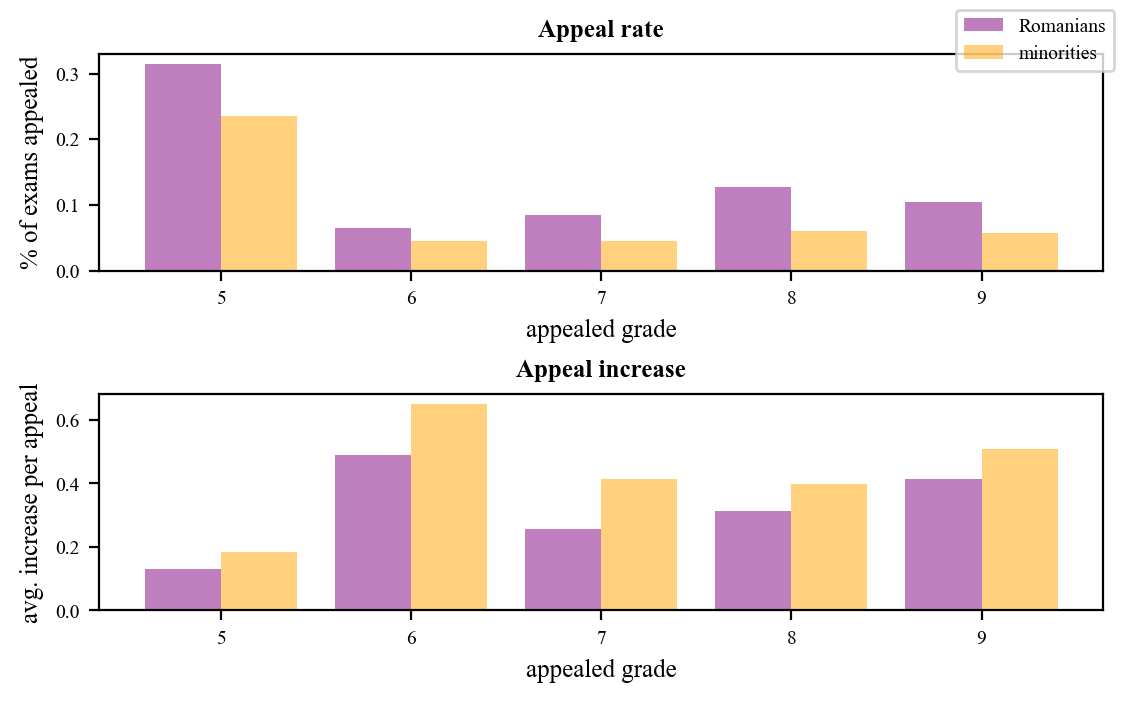

In [10]:
with plt.rc_context(bundles.neurips2021(usetex=False, family='serif')):
    fig, axs = plt.subplots(2, dpi=200)

    bar_width = 0.4
    label_loc = np.arange(5, 10)

    axs[0].set_title("Appeal rate", fontweight="bold")
    axs[0].set_xlabel('appealed grade')
    axs[0].set_ylabel('% of exams appealed')
    axs[0].bar(label_loc - bar_width/2, ro_rates, bar_width, alpha=.5, color='purple')
    axs[0].bar(label_loc + bar_width/2, rp_rates, bar_width, alpha=.5, color='orange')

    axs[1].set_title("Appeal increase", fontweight="bold")
    axs[1].set_xlabel('appealed grade')
    axs[1].set_ylabel('avg. increase per appeal')
    axs[1].bar(label_loc - bar_width/2, ro_incs, bar_width, alpha=.5, color='purple')
    axs[1].bar(label_loc + bar_width/2, rp_incs, bar_width, alpha=.5, color='orange')

    fig.legend(["Romanians", "minorities"])

    plt.show()
    fig.savefig('../doc/plots/exp6_appeal.png', bbox_inches='tight')

In [6]:
# separate dataset into romanians and minorities
romanian_only_results = results_all[results_all['mother_tongue'] == '']
romanian_plus_results = results_all[results_all['mother_tongue'] != '']

# prevent string errors
romanian_only_results.replace('', np.nan, inplace=True)
romanian_plus_results.replace('', np.nan, inplace=True)

# filter both for valid grades
romanian_only_results_f = romanian_only_results[romanian_only_results[ro2] >= 1.0].copy()
romanian_plus_results_f = romanian_plus_results[romanian_plus_results[ro2] >= 1.0].copy()

# calculate the increase from the appeal for each student for both datasets
romanian_only_results_f['inc_ro'] = romanian_only_results_f[ro2] - romanian_only_results_f[ro1]
romanian_plus_results_f['inc_ro'] = romanian_plus_results_f[ro2] - romanian_plus_results_f[ro1]


# calc appeal data for a grade bucket
def bucketize_appeals(ror, rpr, bucket):
    # filter for bucket
    ror = ror[ror['final_grade'] >= bucket].copy()
    ror = ror[ror['final_grade'] < bucket + 1].copy()
    rpr = rpr[rpr['final_grade'] >= bucket].copy()
    rpr = rpr[rpr['final_grade'] < bucket + 1].copy()

    # count the total number of actual appeals in both datasets
    ro_nr = len(ror[ror['romanian_written_appeal'] >= 1.0])
    rp_nr = len(rpr[rpr['romanian_written_appeal'] >= 1.0])

    # appeal rate and avg increase per appeal
    ro_rate = -0.01
    ro_inc = -0.01
    if ro_nr > 0:
        ro_rate = ro_nr / (len(ror) * 3) # 3 exams per student
        ro_inc = ror['inc_ro'].sum() / ro_nr

    rp_rate = -0.01
    rp_inc = -0.01
    if rp_nr > 0:
        rp_rate = rp_nr / (len(rpr) * 4) # 4 exams per student
        rp_inc = rpr['inc_ro'].sum() / rp_nr

    return [[ro_rate, ro_inc], [rp_rate, rp_inc]]

ro_rates = []
ro_incs = []
rp_rates = []
rp_incs = []

for i in range (5, 10):
    a, b = bucketize_appeals(romanian_only_results_f, romanian_plus_results_f, i)
    ro_rates.append(a[0])
    ro_incs.append(a[1])
    rp_rates.append(b[0])
    rp_incs.append(b[1])

C:\Users\cseke\anaconda3\envs\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


C:\Users\cseke\AppData\Local\Temp/ipykernel_15884/1225784928.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(['', '[5, 6)', '[6, 7)', '[7, 8)', '[8, 9)', '[9, 10)'])
C:\Users\cseke\AppData\Local\Temp/ipykernel_15884/1225784928.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(['', '[5, 6)', '[6, 7)', '[7, 8)', '[8, 9)', '[9, 10)'])


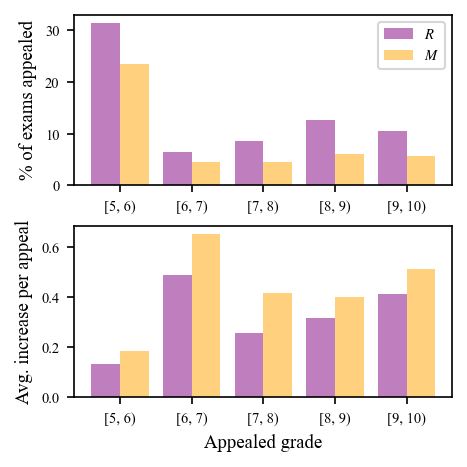

In [32]:
with plt.rc_context(bundles.neurips2021(usetex=False, family='serif')):
    fig, axs = plt.subplots(2, figsize=(3,3), dpi=150)

    bar_width = 0.4
    label_loc = np.arange(5, 10)

    axs[0].set_ylabel('% of exams appealed')
    axs[0].bar(label_loc - bar_width/2, np.asarray(ro_rates) * 100, bar_width, alpha=.5, color='purple')
    axs[0].bar(label_loc + bar_width/2, np.asarray(rp_rates) * 100, bar_width, alpha=.5, color='orange')

    axs[1].set_ylabel('Avg. increase per appeal')
    axs[1].bar(label_loc - bar_width/2, ro_incs, bar_width, alpha=.5, color='purple')
    axs[1].bar(label_loc + bar_width/2, rp_incs, bar_width, alpha=.5, color='orange')

    axs[1].set_xlabel('Appealed grade')
    axs[0].legend(["$\it{R}$", "$\it{M}$"], loc=1)
    axs[0].set_xticklabels(['', '[5, 6)', '[6, 7)', '[7, 8)', '[8, 9)', '[9, 10)'])
    axs[1].set_xticklabels(['', '[5, 6)', '[6, 7)', '[7, 8)', '[8, 9)', '[9, 10)'])

    plt.show()
    fig.savefig('../doc/plots/exp6_appeal_ro.png', bbox_inches='tight')

In [34]:
print(np.asarray(ro_rates).sum() / 5)
print(np.asarray(rp_rates).sum() / 5)

print(np.asarray(ro_incs).sum() / 5)
print(np.asarray(rp_incs).sum() / 5)

0.13921422658151367
0.08872817793495068
0.3206635979990514
0.431153497905143
